In [278]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pprint
import copy
import matplotlib.pyplot as plt
import itertools

# Load datasets

In [186]:
# Load and treat vocab
with open('vocab.txt') as file:
    vocab = file.readlines()
    vocab = [line.rstrip() for line in vocab]

vocab_size = len(vocab)
print('There are %d unique words in our dataset.' % vocab_size)

# Hash table for words to indices and viceversa
word_to_ix = { w:i for i,w in enumerate(vocab) }
ix_to_word = { i:w for i,w in enumerate(vocab) }

There are 20500 unique words in our dataset.


In [185]:
vocab

['',
 '00',
 '0000',
 '000000',
 '001',
 '004',
 '008',
 '01',
 '010',
 '01087',
 '011',
 '012',
 '016',
 '01745',
 '01918',
 '02',
 '020',
 '0201',
 '0208',
 '03',
 '032',
 '04',
 '040',
 '05',
 '052',
 '055',
 '056',
 '057',
 '06',
 '07',
 '0710',
 '0725',
 '08',
 '080',
 '081',
 '09',
 '10',
 '100',
 '1000',
 '10000',
 '10006',
 '10007',
 '10029',
 '10079',
 '10081',
 '101',
 '1010',
 '102',
 '1024',
 '103',
 '1035',
 '104',
 '105',
 '106',
 '107',
 '108',
 '1082',
 '109',
 '11',
 '110',
 '1100',
 '111',
 '1110',
 '112',
 '1123',
 '113',
 '114',
 '115',
 '116',
 '117',
 '1179',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '1250',
 '1251',
 '1252',
 '126',
 '127',
 '128',
 '1282',
 '1284',
 '1285',
 '1288',
 '1291',
 '1296',
 '13',
 '1301',
 '1304',
 '1305',
 '1307',
 '131',
 '1311',
 '1314',
 '1317',
 '132',
 '1320',
 '133',
 '134',
 '137',
 '1370',
 '1377',
 '1394',
 '1395',
 '14',
 '141',
 '142',
 '1423',
 '14443',
 '145',
 '148',
 '1496',
 '15',
 '1500'

In [212]:
# Load training set. Keep 'null' as valid value.
dfs = pd.read_csv('ordered-labels-dataset-subsample.txt', delim_whitespace=True, index_col = 0, keep_default_na = False, header = None, engine='python')

# Build training set with split
dfs['Words'] = dfs.dropna()[2].apply(lambda x: x.split('_'))
words_lists = list(dfs.loc[:,'Words'])

In [213]:
dfs

,1,2,Words
0,,,
32977,dpkg_set_progname,dpkg_set_prog_name,"[dpkg, set, prog, name]"
32978,get_int_attribute,get_int_attribute,"[get, int, attribute]"
32979,finalize_test,finalize_test,"[finalize, test]"
32980,run_psmshell,run_psm_shell,"[run, psm, shell]"
32981,erlang_backingstore_grow,erlang_backings_tore_grow,"[erlang, backings, tore, grow]"
...,...,...,...
329784,sr_dt,sr_dt,"[sr, dt]"
329785,chirp_client_link,chirp_client_link,"[chirp, client, link]"
329786,cgr_preview_forward,cgr_preview_forward,"[cgr, preview, forward]"


In [214]:
# Get stats regarding len of names
dfs['Name_length'] = dfs['Words'].dropna().apply(lambda x: len(x))

dfs['Name_length'].describe()

count    296750.000000
mean          3.656940
std           1.577838
min           1.000000
25%           3.000000
50%           3.000000
75%           5.000000
max          17.000000
Name: Name_length, dtype: float64

# Split train and test. Build probability matrix

In [215]:
# Split in train and test set
X_train, X_test = train_test_split(words_lists, test_size=0.1, random_state=42)

In [267]:
# Number of positions observed
Tx = int(max(dfs['Name_length']))
print('Maximum length of names:', Tx)

# Matrix counting word appearances, row for position, columns for each word (among 20500 words)
word_freq = np.zeros((Tx+1,vocab_size), dtype=np.int32)

for i in range(Tx):
    for word_list in X_train:
        if isinstance(word_list,list) and len(word_list) > i:
            word_freq[i,word_to_ix[word_list[i]] ] += 1

# Last row: sum of appearances of each word
for j in range(vocab_size):
    word_freq[Tx,j] = sum(word_freq[:,j])
            
word_freq

Maximum length of names: 17


array([[ 0,  8,  0, ...,  1,  1,  0],
       [ 0, 53,  0, ...,  0,  0,  1],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 68,  2, ...,  1,  1,  2]])

In [259]:
# Words not appearing in training set:
sum(word_freq[Tx,:] == 0)

1561

In [272]:
word_freq_normalized = word_freq[:Tx,:].astype(np.float32)

# Normalize
for j in range(vocab_size):
    if sum(word_freq_normalized[:,j]) != 0:
        word_freq_normalized[:,j] /= sum(word_freq_normalized[:Tx,j])

In [270]:
# Summary of obtained matrices
print(np.shape(word_freq))
print(word_freq[:18,:20])

(18, 20500)
[[ 0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 53  0  0  9  0  0  3  0  0  0  2  0  0  0  1  0  3  0  0]
 [ 0  0  1  2  0  1  0  2  0  0  0  0  0  1  1  5  0  0  0  1]
 [ 0  4  1  1  0  0  1  4  2  0  1  0  0  0  0 16  1  0  1  1]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [273]:
print(np.shape(word_freq_normalized))
print(word_freq_normalized[:18,:5])

(17, 20500)
[[0.         0.11764706 0.         0.         0.        ]
 [0.         0.7794118  0.         0.         1.        ]
 [0.         0.         0.5        0.6666667  0.        ]
 [0.         0.05882353 0.5        0.33333334 0.        ]
 [0.         0.02941176 0.         0.         0.        ]
 [0.         0.01470588 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


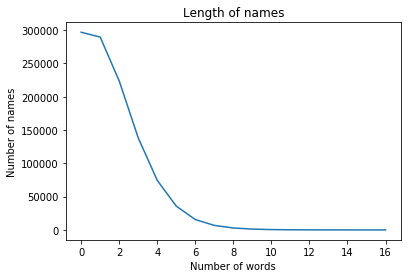

In [191]:
# Plot showing length of names
plt.plot([sum(word_freq[x,:]) for x in range(17)])
plt.title('Length of names')
plt.ylabel('Number of names')
plt.xlabel('Number of words')
plt.show()

# Model

In [305]:
def obtain_probabilities(word_list):
    permutations = list(itertools.permutations(word_list, len(word_list)))
    print(permutations)
    probs = np.zeros(len(permutations))
    for ix, permutation in enumerate(permutations):
        prob_tmp = 1
        for i in range(len(permutation)):
            prob_tmp *= word_freq_normalized[ i, word_to_ix[permutation[i]] ]
            print(word_freq_normalized[ :, word_to_ix[permutation[i]] ])
        probs[ix] = prob_tmp
    
    return probs

In [307]:
obtain_probabilities(['gdalget','gdu'])

[('gdalget', 'gdu'), ('gdu', 'gdalget')]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.9655172  0.03448276 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.9655172  0.03448276 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0.03448276, 0.        ])